In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Packages.ClusteringHelper as ch
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
from Packages.TimeEvolving import Cluster

In [3]:
text, data = ch.read_aida_yago_conll(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\AIDA-YAGO2-dataset.tsv")
save = False
if save:
    text_file = open('text.txt', 'w')
    text_file.write(text)
    text_file.close()
data

,documents,tokens,indexes,word_indexes,mentions,entities,wikidatas,numeric_codes,alpha_codes
0,0,EU,"(0, 2)",0,,,,,
1,0,rejects,"(3, 10)",1,,,,,
2,0,German,"(11, 17)",2,German,Germany,http://en.wikipedia.org/wiki/Germany,11867,/m/0345h
3,0,call,"(18, 22)",3,,,,,
4,0,to,"(23, 25)",4,,,,,
...,...,...,...,...,...,...,...,...,...
285584,1392,younger,"(1342, 1349)",265,,,,,
285585,1392,brother,"(1350, 1357)",266,,,,,
285586,1392,",","(1358, 1359)",267,,,,,
285587,1392,Bobby,"(1360, 1365)",268,Bobby,Bobby_Charlton,http://en.wikipedia.org/wiki/Bobby_Charlton,4224,/m/01c8x


In [4]:
ents_data = data[data['entities'] != ''].copy()

In [5]:
from pathlib import Path

path_train = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_train_encodings.jsonl")
path_testa = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testa_encodings.jsonl")
path_testb = Path(
    "D:\\Sgmon\\Documents\\Magistrale\\TESI\\ClusteringAndLinking\\aida-yago2-dataset\\encodings\\AIDA-YAGO2_testb_encodings.jsonl")
raw_encodings_train = open(path_train, 'r').read()
raw_encodings_testa = open(path_testa, 'r').read()
raw_encodings_testb = open(path_testb, 'r').read()

In [6]:
import json

jsonl_parsed_train = [json.loads(x) for x in raw_encodings_train.splitlines()]
jsonl_parsed_testa = [json.loads(x) for x in raw_encodings_testa.splitlines()]
jsonl_parsed_testb = [json.loads(x) for x in raw_encodings_testb.splitlines()]
jsonl_parsed = jsonl_parsed_train + jsonl_parsed_testa + jsonl_parsed_testb

In [7]:
encodings = [x['encoding'] for x in jsonl_parsed]

In [8]:
ents_data['encodings'] = encodings
# ents_data_filtered = ch.filter_data(ents_data, 3)
ents_data_filtered = ents_data.copy()

In [9]:
ents_data = ents_data_filtered[ents_data_filtered['entities'] != '']
entities = ents_data['entities'].values
mentions = ents_data['tokens'].values
encodings = ents_data['encodings'].values
unique_entities = np.unique(entities)
gold_standard = Counter(entities)
gold_standard = dict(sorted(gold_standard.items(), key=lambda item: item[1], reverse=True))

In [10]:
leven_cluster = np.loadtxt("../aida-yago2-dataset/damerau_1_2.txt", dtype=np.int32)
lev_cluster_dict = {}
for i, x in enumerate(leven_cluster):
    try:
        lev_cluster_dict[x].append(
            (mentions[i], entities[i], encodings[i]))
    except:
        lev_cluster_dict[x] = [
            (mentions[i], entities[i], encodings[i])]

In [20]:
cluster_all = []
from sklearn.cluster import AgglomerativeClustering
clusterizator = AgglomerativeClustering(n_clusters=None, affinity='cosine',
                                        distance_threshold=0.029085082846423638, linkage="single")

for x in lev_cluster_dict:
    encodings = [y[2] for y in lev_cluster_dict[x]]
    if len(encodings) > 1:
        cluster = clusterizator.fit_predict(encodings)
        cluster_all.append(cluster)
    else:
        cluster_all.append(np.zeros(1))

In [21]:
total_encodings = [[y[2] for y in lev_cluster_dict[x]] for x in lev_cluster_dict.keys()]
clustered_entities = [[row[1] for row in lev_cluster_dict[index]] for index in lev_cluster_dict.keys()]
clustered_mentions = [[row[0] for row in lev_cluster_dict[index]] for index in lev_cluster_dict.keys()]

In [22]:
# clusters_splitted = []
# clusters_vectors = []
# for n_cluster in range(len(clustered_entities)):
#     cluster_unique = dict.fromkeys(set(cluster_all[n_cluster]), [])
#     cluster_unique_vector = dict.fromkeys(set(cluster_all[n_cluster]), [])
#     for key in cluster_unique:
#         cluster_unique[key] = [clustered_entities[n_cluster][index] for index in
#                                range(len(clustered_entities[n_cluster])) if cluster_all[n_cluster][index] == key]
#         cluster_unique_vector[key] = [total_encodings[n_cluster][index] for index in
#                                range(len(clustered_entities[n_cluster])) if cluster_all[n_cluster][index] == key]
#     clusters_vectors.append(cluster_unique_vector)
#     clusters_splitted.append(cluster_unique)

In [23]:
clusters_splitted = []
clusters_vectors = []
for n_cluster in range(len(clustered_entities)):
    cluster_unique = {k:Cluster() for k in set(cluster_all[n_cluster])}
    for key in cluster_unique:
        cl_mentions = [clustered_mentions[n_cluster][index] for index in
                               range(len(clustered_mentions[n_cluster])) if cluster_all[n_cluster][index] == key]
        cl_entities = [clustered_entities[n_cluster][index] for index in
                               range(len(clustered_entities[n_cluster])) if cluster_all[n_cluster][index] == key]
        cl_encodings = [total_encodings[n_cluster][index] for index in
                               range(len(clustered_entities[n_cluster])) if cluster_all[n_cluster][index] == key]
        cluster_unique[key] = Cluster(entities=cl_entities, mentions=cl_mentions,encodings_list=cl_encodings)
    clusters_splitted.append(cluster_unique)

In [24]:
# clusters_splitted_vector_dict = [np.mean(x[y], axis=0)  for x in clusters_vectors for y in x]
# clusters_splitted_vector_dict = [np.median(x[y], axis=0)  for x in clusters_vectors for y in x]

In [25]:
clusters_splitted_dict = [x[y] for x in clusters_splitted for y in x]

In [26]:
ceaf_list = []
b3_list = []
for soglia in tqdm([0.005, 0.009, 0.013, 0.0155, .017,0.02]):
    clusterizator = AgglomerativeClustering(n_clusters=None, affinity='cosine',
                                            distance_threshold=soglia, linkage="single")

    clusters_of_cluster = clusterizator.fit_predict([x.encodings_median() for x in clusters_splitted_dict])
    len(set(clusters_of_cluster))

    coc_dict = {k: Cluster() for k in set(clusters_of_cluster)}
    for index, el in enumerate(clusters_of_cluster):
        coc_dict[el] = coc_dict[el] + clusters_splitted_dict[index]
    len(coc_dict.keys())

    import Packages.ClusteringHelper as ch
    golden_standard_dict = ch.get_gold_standard_dict(ents_data)

    list_of_counter = [x.count_ents() for x in coc_dict.values()]
    print('Counter finito')
    from tqdm.notebook import tqdm
    # B-cubed
    bcubed_precision_num = 0
    bcubed_recall_num = 0
    for cluster in tqdm(list_of_counter):
        for gold_key in golden_standard_dict.keys():
            try:
                bcubed_precision_num = bcubed_precision_num + (pow(cluster[gold_key], 2) /
                                           sum(cluster.values()))
                bcubed_recall_num = bcubed_recall_num + (pow(cluster[gold_key], 2) /
                                           golden_standard_dict[gold_key])
            except:
                pass

    bcubed_precision = bcubed_precision_num/sum([x.n_elements() for x in coc_dict.values()])
    bcubed_recall = bcubed_recall_num/ents_data.shape[0]


    bcubed_f1 = (2 * (bcubed_recall * bcubed_precision)) / (
            bcubed_precision + bcubed_recall)

    best_alignment = ch.get_optimal_alignment([x.count_ents() for x in coc_dict.values()], set(entities),
                                              is_dict=False)


    # CEAFm_precision
    CEAFm_p = sum(best_alignment.values()) / len(entities)

    # CEAFm_recall
    CEAFm_r = sum(best_alignment.values()) / sum([x.n_elements() for x in coc_dict.values()])

    CEAFm_f1 = 2 * (CEAFm_p * CEAFm_r) / (CEAFm_p + CEAFm_r)
    ceaf_list.append(CEAFm_f1)
    b3_list.append(bcubed_f1)

  0%|          | 0/6 [00:00<?, ?it/s]

Counter finito


  0%|          | 0/6545 [00:00<?, ?it/s]

Counter finito


  0%|          | 0/6544 [00:00<?, ?it/s]

Counter finito


  0%|          | 0/6528 [00:00<?, ?it/s]

Counter finito


  0%|          | 0/6494 [00:00<?, ?it/s]

Counter finito


  0%|          | 0/6460 [00:00<?, ?it/s]

Counter finito


  0%|          | 0/6368 [00:00<?, ?it/s]

In [30]:
x = [0.005, 0.009, 0.013, 0.0155, .017,0.02]
media_ceaf_list =[0.8098644713664306, 0.8147895172017112, 0.8349210914189165, 0.8465686450731568, 0.84268612718841, 0.7775101556602078]

In [31]:
media_b3_list = [0.8547765911567878, 0.8580373142330895, 0.8723254904088633, 0.8815287136787912, 0.8791856883231381, 0.8431879426873976]

In [32]:
median_ceaf_list=[0.8098644713664306, 0.8100442175647985, 0.8274436495668117, 0.8408886652047308, 0.84027752813028, 0.7772225617428191]

In [33]:
median_b3_list=[0.8547765911567892, 0.8549326563451675, 0.8669704022515207, 0.8762783852863338, 0.8765328255873664, 0.8429318842672814]

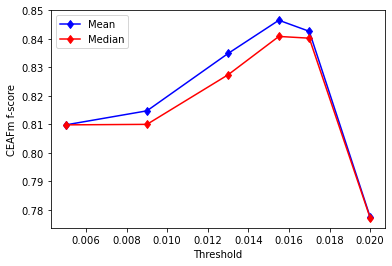

In [34]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, media_ceaf_list, label='Mean', color='blue', marker='d')
ax.plot(x, median_ceaf_list, label='Median', color='red', marker='d')
ax.legend(loc='upper left')
plt.xlabel('Threshold')
plt.ylabel('CEAFm f-score')
plt.savefig('ceafmmean_3step.png')

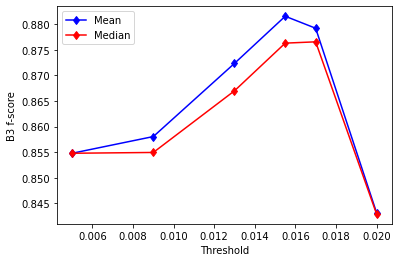

In [35]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, media_b3_list, label='Mean', color='blue', marker='d')
ax.plot(x, median_b3_list, label='Median', color='red', marker='d')
ax.legend(loc='upper left')
plt.xlabel('Threshold')
plt.ylabel('B3 f-score')
plt.savefig('b3mean_3step.png')